In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
#import basic databased
#Data visualization as follows

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [6]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
#check missings in dataset train_data

print(f"In training data:\n{pd.isnull(train_data).sum()}\n\nIn testing data:\n{pd.isnull(test_data).sum()}")

In training data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In testing data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


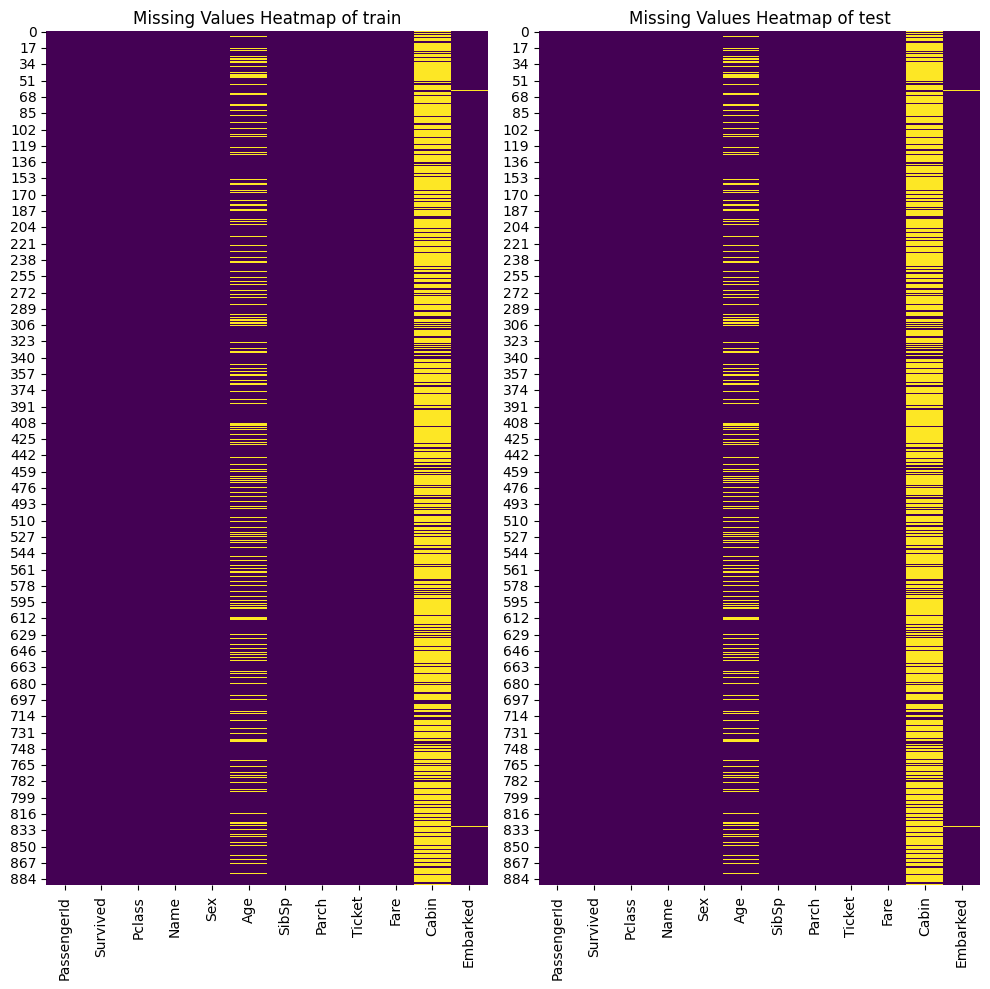

In [9]:
#Visualize the missing values

fig,(left,right) = plt.subplots(1,2,figsize=(10,10))

sns.heatmap(train_data.isnull(),cbar=False,cmap='viridis',ax=left)
sns.heatmap(train_data.isnull(),cbar=False,cmap='viridis',ax=right)
left.set_title('Missing Values Heatmap of train')
right.set_title('Missing Values Heatmap of test')
plt.tight_layout()
plt.show()

In [10]:
#show the datatype of each feature

print(f"{train_data.info()}{test_data.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

#Methods we take here to fill the missing values ('Age')
#By modeling the features with missing value as a function of other features in a "round-robin fashion" 
#"round-robin fashion": everyone gets a equal turn in a circular order
mice_imputer = IterativeImputer()
feature_missings = ['Age']
train_data[feature_missings] = mice_imputer.fit_transform(train_data[feature_missings])
test_data[feature_missings] = mice_imputer.fit_transform(test_data[feature_missings])

print(f"The number of missing 'Age' values in train data is: {pd.isnull(train_data['Age']).sum()}\n")
print(f"The number of missing 'Age' values in test data is: {pd.isnull(test_data['Age']).sum()}")

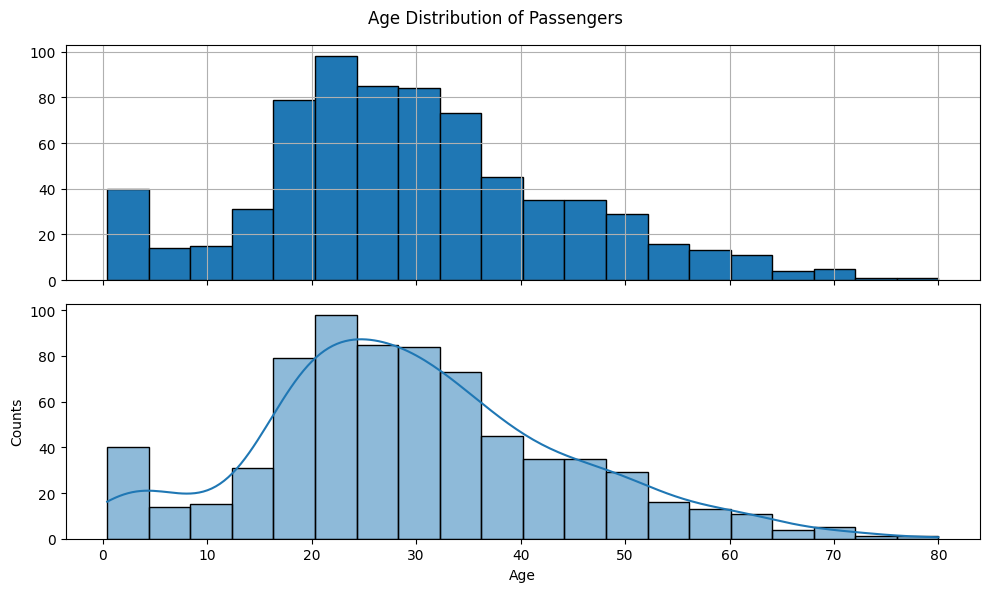

In [11]:
#Visualize the distribution of age

fig,(axtop,axbottom) = plt.subplots(2,1,sharex=True,figsize=(10, 6))

train_data['Age'].hist(bins=20,edgecolor='k',ax=axtop)
sns.histplot(train_data['Age'],bins=20,kde=True,ax=axbottom)
plt.suptitle('Age Distribution of Passengers')
plt.ylabel('Counts')
plt.xlabel('Age')
plt.tight_layout()
plt.show()

In [12]:
#Fill the 'Embarked' value with 'S' -- according to historic fact

train_data['Embarked'] = train_data['Embarked'].fillna('S')
test_data['Embarked'] = test_data['Embarked'].fillna('S')

print(f"The number of missing 'Embarked' value in train data is: {pd.isnull(train_data['Embarked']).sum()}\n")
print(f"The number of missing 'Embarked' value in test data is: {pd.isnull(test_data['Embarked']).sum()}")

The number of missing 'Embarked' value in train data is: 0

The number of missing 'Embarked' value in test data is: 0


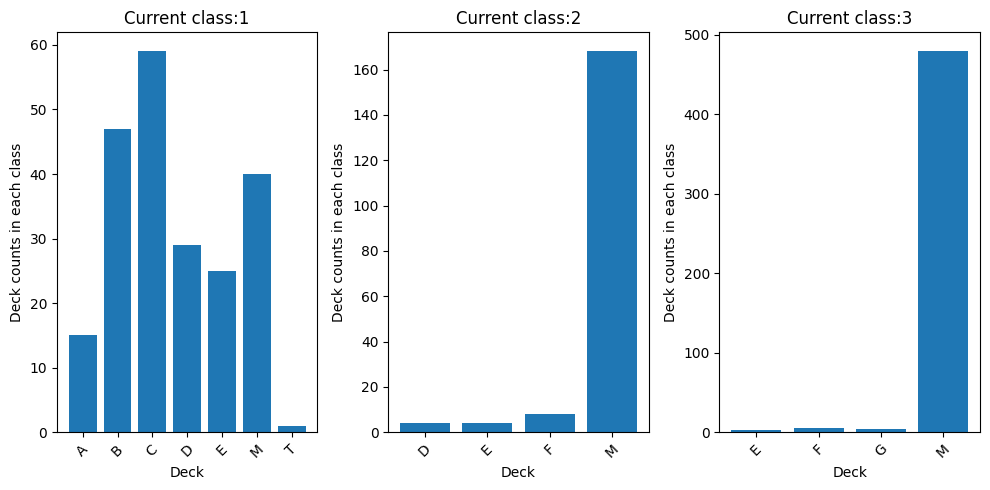

In [13]:
#Fact: There is a distribution of Cabin from 'A' to 'P', where A ~ C are for 1st class passengers, 
#      D, E are for all classes
#      F,G are for both 2nd and 3rd class passengers
#Visualize 1): show the deck distribution of each class

def definevalue(df):
    if pd.notnull(df):
        df = df[0]
    else:
        df = 'M'
    return df
    
train_data['Deck'] = train_data['Cabin'].apply(definevalue)
test_data['Deck'] = test_data['Cabin'].apply(definevalue)

decks_class = train_data.groupby(['Pclass','Deck']).count().drop(columns=['Survived','Name','Sex',
                                                                  'Age','SibSp','Parch','Fare',
                                                                'Embarked','Cabin','PassengerId','Ticket']).transpose()

fig,ax = plt.subplots(1,3,figsize=(10,5))

classes = [1,2,3]

for i in range(0,3):
    classnow = classes[i]
    classdata = train_data[train_data['Pclass'] == classnow]
    deckcounts = classdata['Deck'].drop(columns = ['M']).value_counts().sort_index()
    
    ax[i].bar(deckcounts.index,deckcounts.values)
    ax[i].set_title(f'Current class:{i+1}')
    ax[i].set_ylabel('Deck counts in each class')
    ax[i].set_xlabel('Deck')
    ax[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


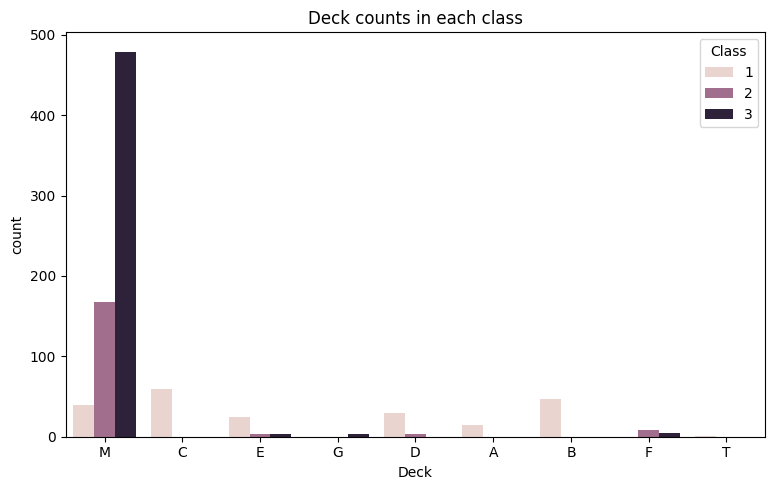

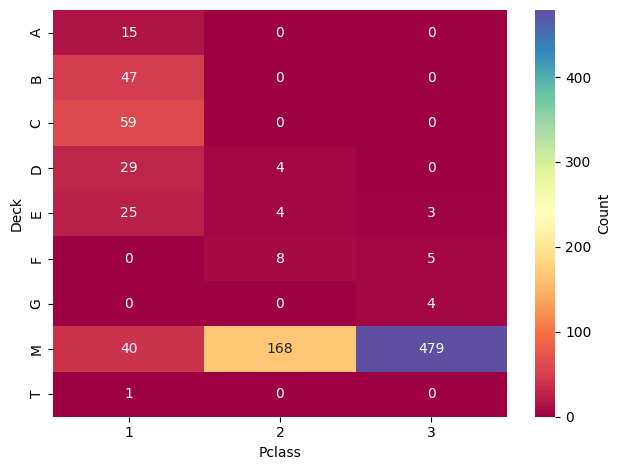

In [14]:
#Visulize 2)
# a. combine the deck counts for three different classed
# b. using heatplot to demonstrate the count number of each deck

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.countplot(data = train_data,x = 'Deck',hue = 'Pclass')
plt.title('Deck counts in each class')
plt.tight_layout()
plt.legend(title = 'Class')
plt.show()

cross_tab = pd.crosstab(train_data['Deck'],train_data['Pclass'])

sns.heatmap(cross_tab,annot=True,fmt='d',cmap='Spectral',cbar_kws={'label': 'Count'})
plt.tight_layout()
plt.show()

In [15]:
#Change all passengers in 'T' to 'A'
change1 = train_data[train_data['Deck'] == 'T'].index
change2 = test_data[test_data['Deck'] == 'T'].index
train_data.loc[change1,'Deck'] == 'A'
test_data.loc[change2,'Deck'] == 'A'

Series([], Name: Deck, dtype: bool)

In [16]:
# Visualize 3): plot the survival percentage of each deck and then decide the division of decks


def show_survival(df):
    survival_number = df.groupby(["Deck", "Survived"]).size().unstack(fill_value=0)
    survival_rate = df.groupby("Deck")["Survived"].agg(["mean", "count"]).round(4)
    survival_rate.columns = ["Survival_Rate", "Passenger_Count"]
    result = survival_number.join(survival_rate)
    result["Survival_Rate"] = (result["Survival_Rate"] * 100).round(4)
    return result


show_survival(train_data)

,0,1,Survival_Rate,Passenger_Count
Deck,,,,
A,8,7,46.67,15
B,12,35,74.47,47
C,24,35,59.32,59
D,8,25,75.76,33
E,8,24,75.00,32
F,5,8,61.54,13
G,2,2,50.00,4
M,481,206,29.99,687
T,1,0,0.00,1


In [17]:
# Finally,we replace 'A', 'B', 'C' with 'ABC',
# 'D', 'E' with 'DE',and 'F', 'G' with 'FG'.

train_data["Deck"] = train_data["Deck"].replace(["A", "B", "C", "T"], "ABC")
train_data["Deck"] = train_data["Deck"].replace(["D", "E"], "DE")
train_data["Deck"] = train_data["Deck"].replace(["F", "G"], "FG")
train_data["Deck"].value_counts()

Deck
M      687
ABC    122
DE      65
FG      17
Name: count, dtype: int64

In [18]:
# No need for 'Cabin' now, we will drop it

train_data.drop(['Cabin'], inplace=True, axis=1)
test_data.drop(['Cabin'], inplace=True, axis=1)

In [19]:
#Now check the missing values again

for i in ['Survived','Name','Sex','Age','SibSp','Parch','Fare','Embarked','PassengerId','Ticket']:
    print(f"The number of missing {i} value in training set is: {pd.isnull(train_data[i]).sum()}\n")


for i in ['Name','Sex','Age','SibSp','Parch','Fare','Embarked','PassengerId','Ticket']:
    print(f"\nThe number of missing {i} value in tesing set is: {pd.isnull(test_data[i]).sum()}\n")


The number of missing Survived value in training set is: 0

The number of missing Name value in training set is: 0

The number of missing Sex value in training set is: 0

The number of missing Age value in training set is: 177

The number of missing SibSp value in training set is: 0

The number of missing Parch value in training set is: 0

The number of missing Fare value in training set is: 0

The number of missing Embarked value in training set is: 0

The number of missing PassengerId value in training set is: 0

The number of missing Ticket value in training set is: 0


The number of missing Name value in tesing set is: 0


The number of missing Sex value in tesing set is: 0


The number of missing Age value in tesing set is: 86


The number of missing SibSp value in tesing set is: 0


The number of missing Parch value in tesing set is: 0


The number of missing Fare value in tesing set is: 1


The number of missing Embarked value in tesing set is: 0


The number of missing Passenge

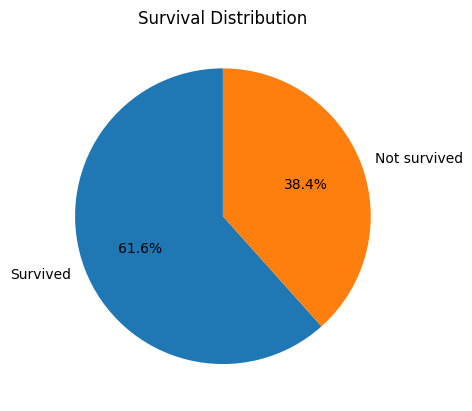

The total amount of survived passengers is: 342

The total amount of survived passengers is: 549


In [20]:
# Visualize given data -- Survivals in train_data

survived = train_data["Survived"].value_counts()[1]
notsurvived = train_data["Survived"].value_counts()[0]

survival_rate = survived / train_data.shape[0] * 100  # %
notsurvival_rate = notsurvived / train_data.shape[0] * 100  # %

plt.pie(
    train_data["Survived"].value_counts(),
    autopct="%1.1f%%",
    labels=["Survived", "Not survived"],
    startangle=90,
)
plt.title("Survival Distribution")
plt.show()

print(
    f"The total amount of survived passengers is: {survived}\n\nThe total amount of survived passengers is: {notsurvived}"
)

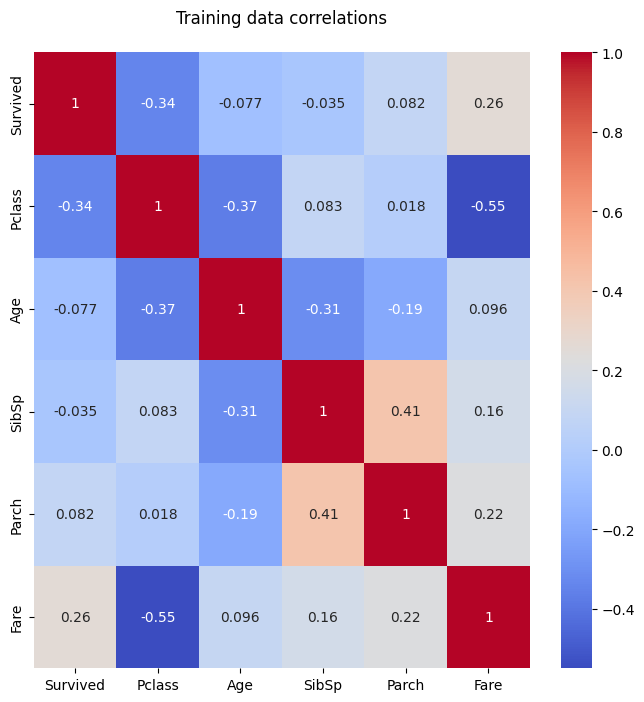

In [21]:
#Calculate the correlations between survival 
plt.figure(figsize=(8,8))

sns.heatmap(train_data.drop(['PassengerId','Name','Sex','Deck','Ticket','Embarked'],axis=1).corr(),annot=True,cmap='coolwarm')
plt.title('Training data correlations\n')
plt.show()

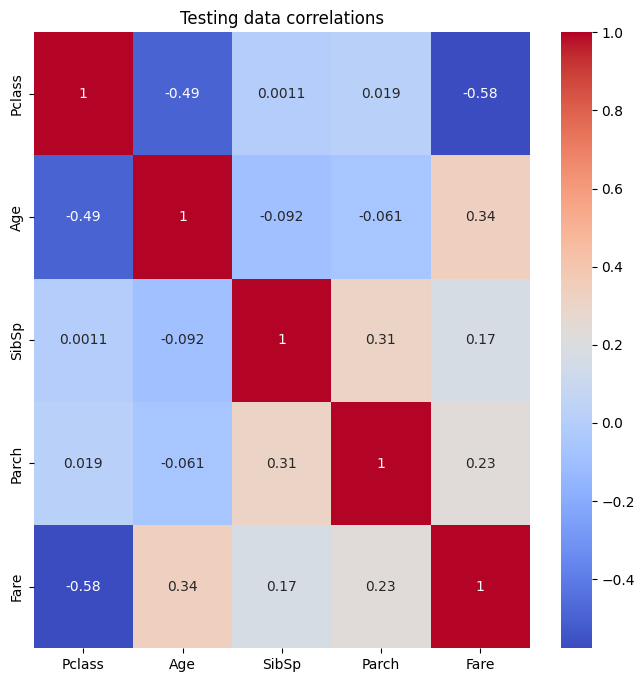

In [22]:
#Calculate the correlations in test dataset
plt.figure(figsize=(8.0,8.0))

sns.heatmap(test_data.drop(['PassengerId','Name','Sex','Deck','Ticket','Embarked'],axis=1).corr(),annot=True,cmap='coolwarm')
plt.title('Testing data correlations')
plt.show()

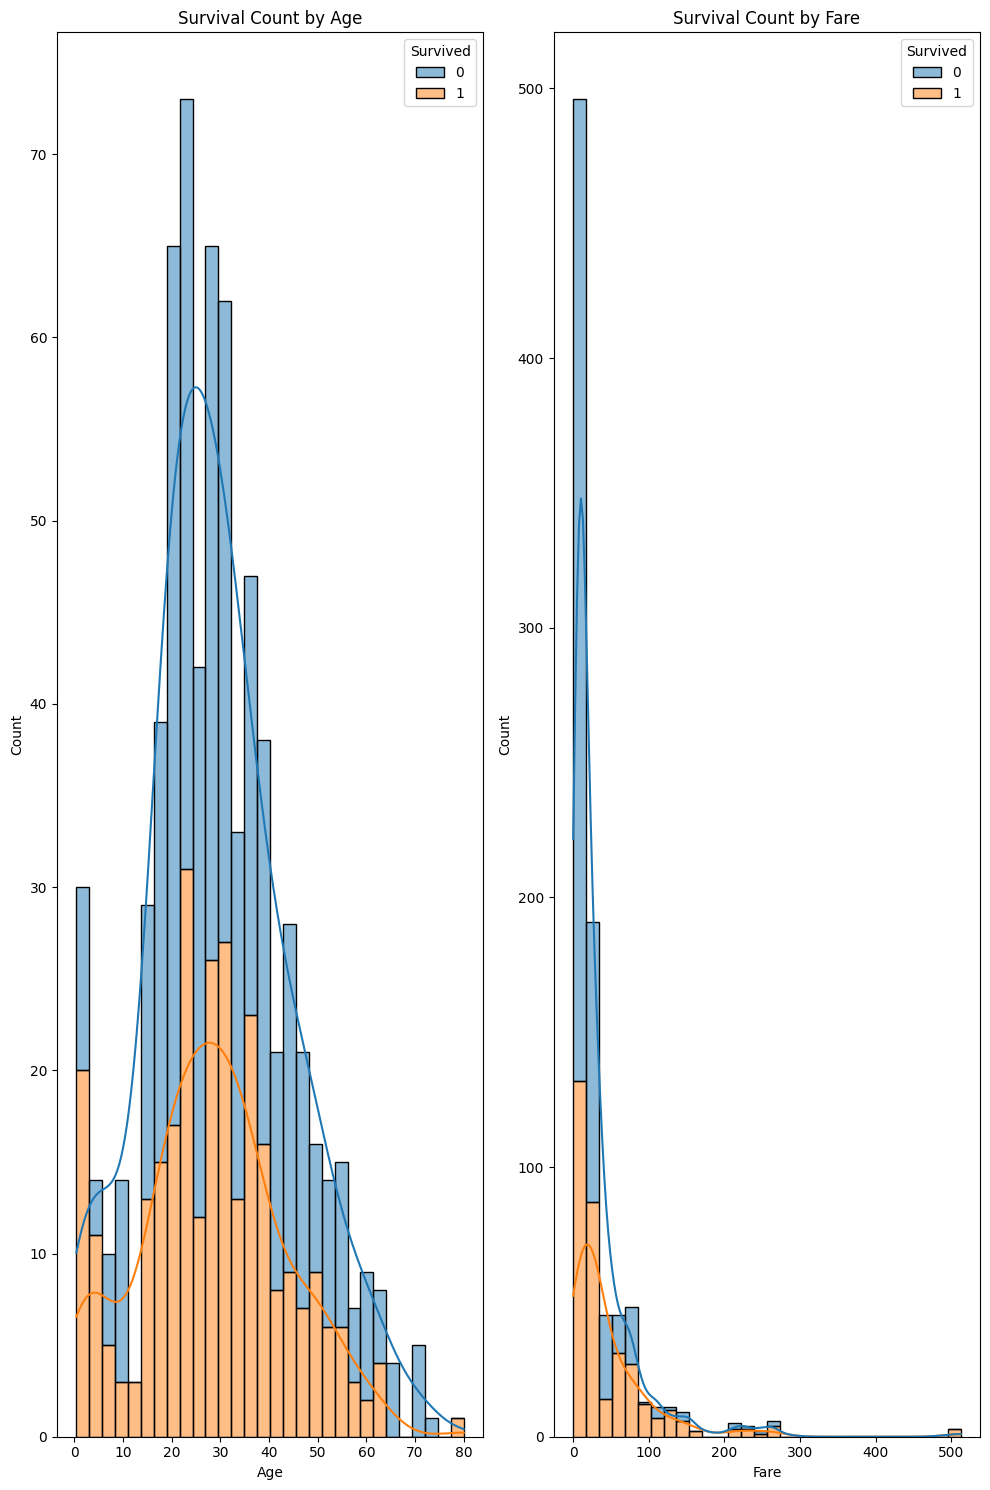

In [23]:
#Visualize 'Age' vs 'Survived'
fig,ax = plt.subplots(1,2,figsize=(10,15))
plt.subplots_adjust(right=1.5)

for i,feature in enumerate(['Age','Fare']):
    sns.histplot(data=train_data,x=feature,hue='Survived',multiple='stack',ax=ax[i],bins=30,kde=True)
    ax[i].set_title(f'Survival Count by {feature.capitalize()}')
    ax[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

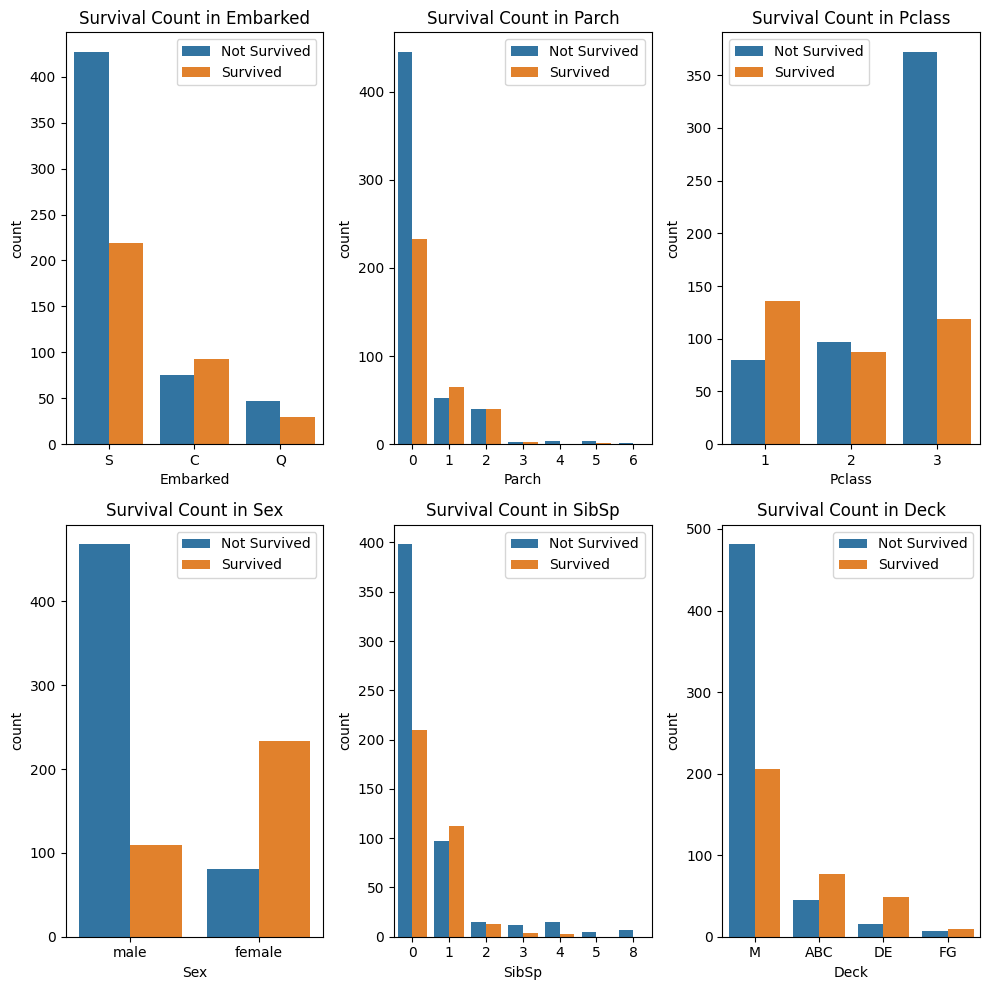

In [24]:
# Now we are going to visualize the survivals in each feature seperately

tar_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig,ax = plt.subplots(2,3,figsize=(10,10))
for i,feature in enumerate(tar_features,1):
    plt.subplot(2,3,i)
    sns.countplot(data=train_data,x=feature,hue='Survived')
    plt.title('Survival Count in {}'.format(feature))
    plt.legend(['Not Survived','Survived'])
    plt.tick_params(axis='y')

plt.tight_layout()
plt.show()

Most of the features are correlated with each other, but we are aiming to find or create individual feature that are less correlated from each other in order to make the prediction model recieve less "noise" and improve the accuracy. Some features can be combined with other features, they alltogether can be made into a new feature, for example "Family". 

We already analyze "Cabin" feature and created the "Deck" feature instead. 

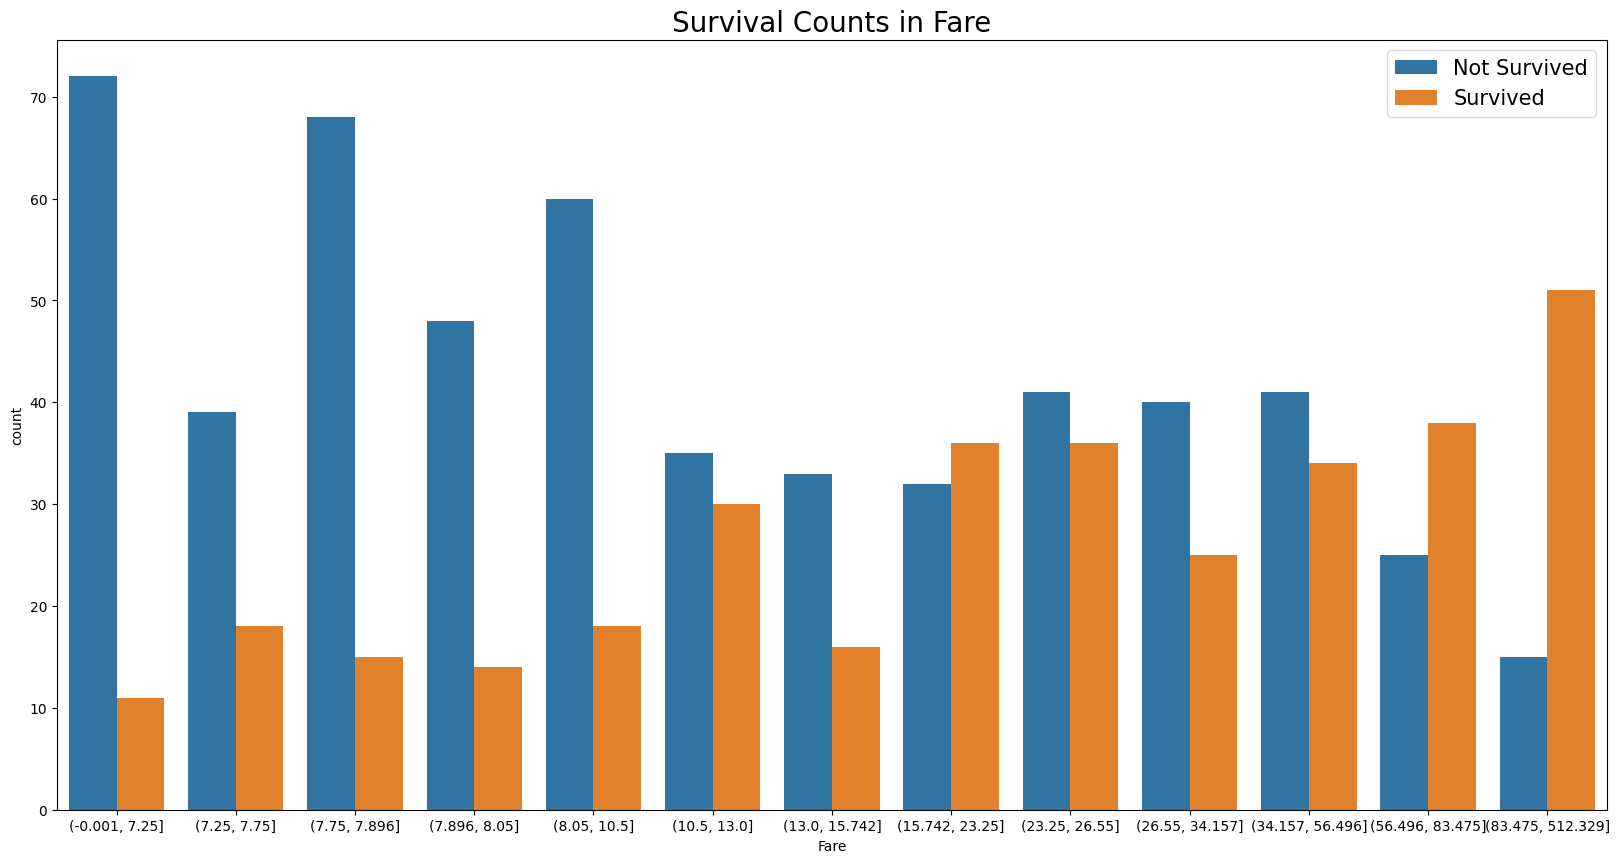

In [25]:
# Start with 'Fare'
# Visualize the survival count

all_data = pd.concat([train_data,test_data],sort=True).reset_index(drop=True)
def plotthis(all_data):
    df = all_data.copy()
    df['Fare'] = pd.qcut(df['Fare'],13)  # Divide fare into 13 intervals

    plt.figure(figsize=(20,10))
    sns.countplot(data=df,x='Fare',hue='Survived')

    plt.legend(['Not Survived','Survived'],prop={'size':15})
    plt.title('Survival Counts in {}'.format('Fare'),size=20)

plotthis(all_data)
plt.show()

In general, the survival rate saw an increase as the 'Fare', or you can say the money they paid for ticket, goes up.

The distribution of Survivals in Age Follows a normal distribution (shown above)

Here comes another question: 

As 'SibSp' and 'Parch' are two features highly connected to each other, and them together is representing passengers in groups as a family. However, it ignores the situation of friends' group. 

So instead of create a new "Family" feature, we should analyze the 'Ticket' feature as passengers in the same group (family, friends) would be more likely to purchase the same ticket. 

By the value counts of 'Ticket', we can divide passengers into groups more effectively. 

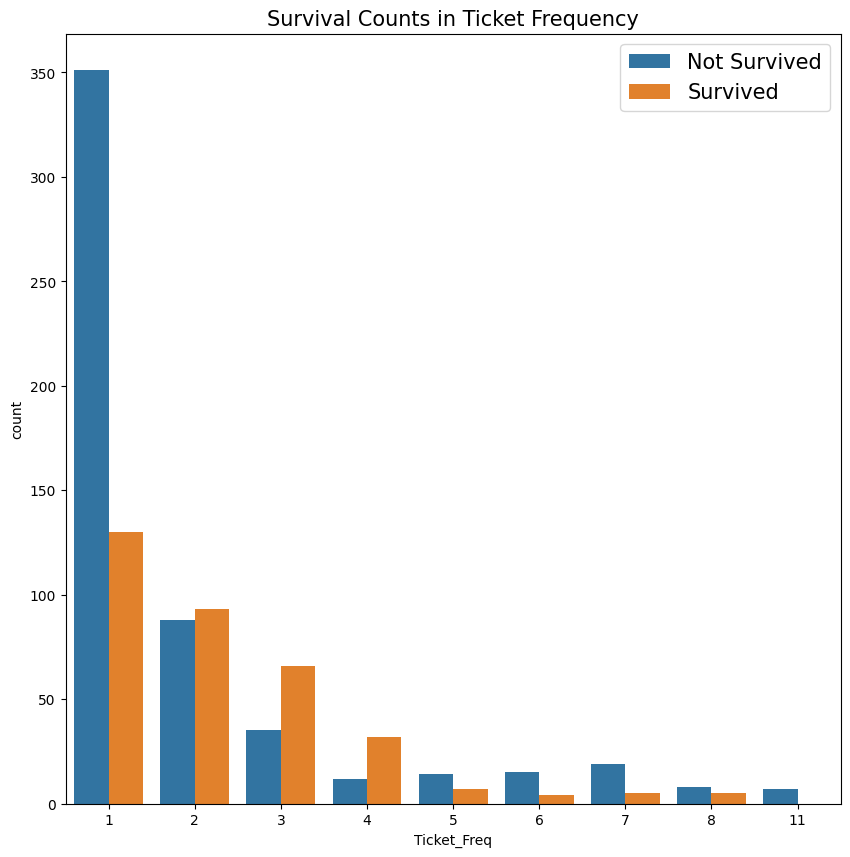

In [26]:
# Implement the division and visualize the ticket_frequency survival distribution

all_data['Ticket_Freq'] = all_data.groupby('Ticket')['Ticket'].transform('count')

plt.figure(figsize=(10,10))

sns.countplot(data=all_data,x='Ticket_Freq',hue='Survived')
plt.legend(['Not Survived','Survived'],prop={'size':15})
plt.title('Survival Counts in {}'.format('Ticket Frequency'),size=15)

plt.show()

Now take a look at 'Name' feature, everyone's name is different while titles like  Mr.,Ms are commonly used for everyone. Also, some title like "Lady" are incorrectly recorded, we can replace them by a general female title category "Miss/Mrs/Ms". 

Here we group 'Name' feature and create a new feature 'Title'

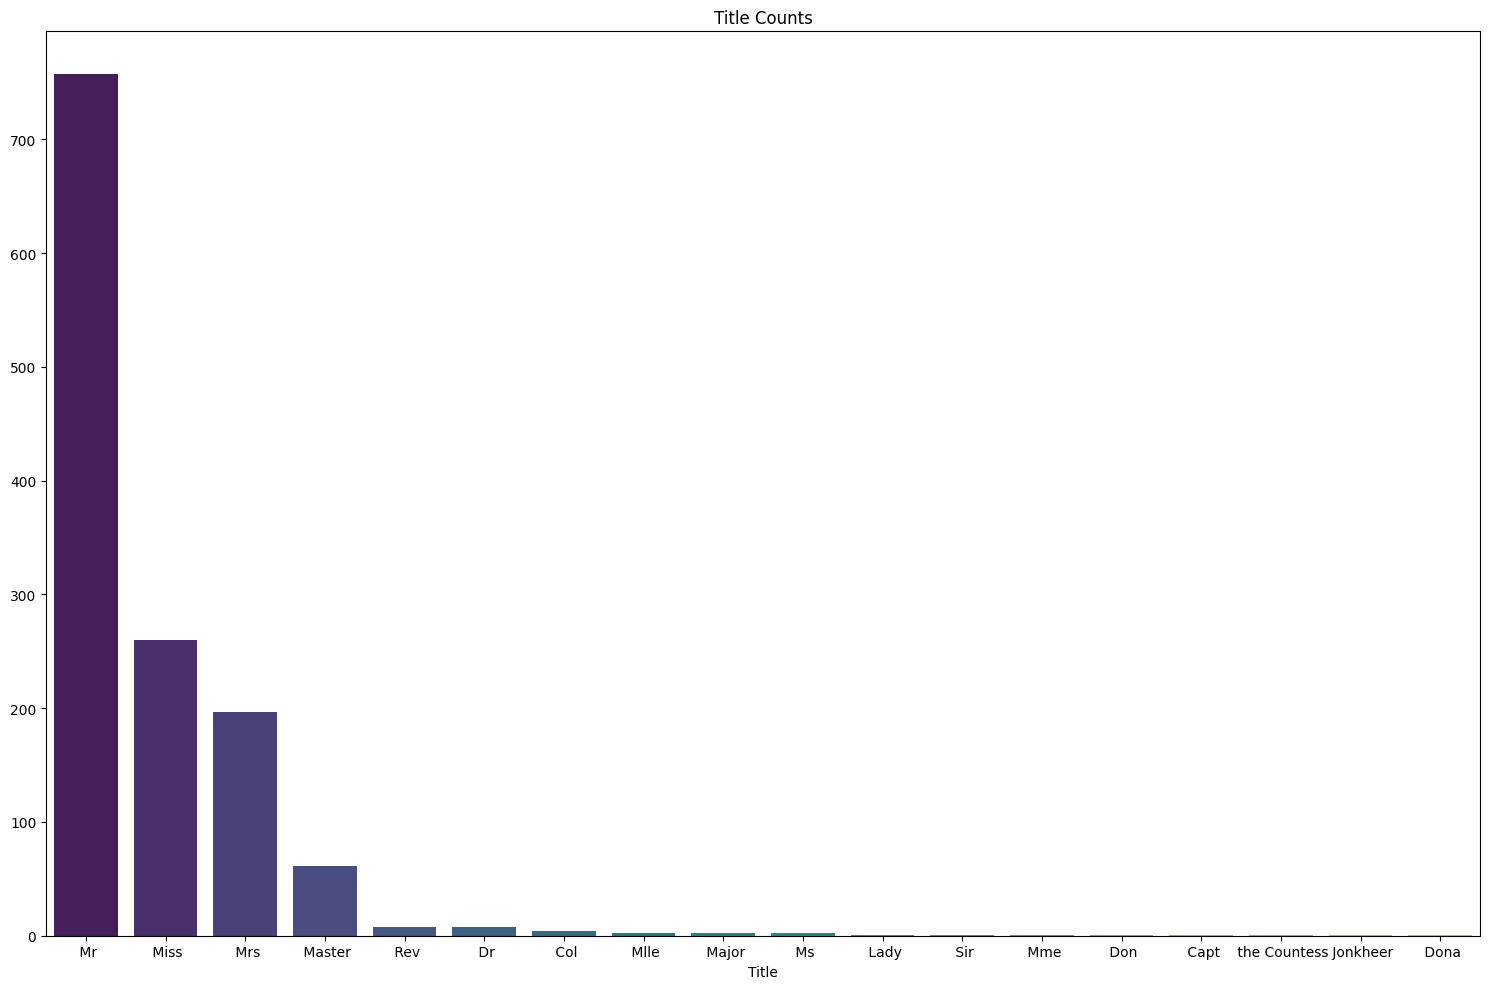

In [27]:
# This step first split the name by dividing 'Name' from comma, and then select the first element of the 
# name which is the real 'Title'

all_data['Title'] = all_data['Name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0]

# Now we visiualize the distribution of titles

plt.figure(figsize=(15,10))
sns.barplot(x=all_data['Title'].value_counts().index,y=all_data['Title'].value_counts().values,palette='viridis')
plt.title('Title Counts')

plt.tight_layout()
plt.show()

 Now we start to divide and regroup titles
 'Miss','Mrs','Ms','Mlle','Lady','Mme','the Countess','Dona' will become a general female title
 'Dr','Col','Sir','Major','Jonkheer','Capt','Don','Rev' will become a general special title

It is important to remove the blank before the index
all_data['Title'] = all_data['Title'].str.strip()

all_data['Title'] = all_data['Title'].replace(['Miss','Mrs','Ms','Mlle','Lady','Mme','the Countess','Dona'], 'Miss/Mrs/Ms')
all_data['Title'] = all_data['Title'].replace(['Dr','Col','Sir','Major','Jonkheer','Capt','Don','Rev'], 'Dr/Army/Noble/Clergy')

#### Review for the fisrt draft: 
The former division didn't show a clear survival rate relations, so now we leave the 'Master' part and divide else into Mr and Mrs

In [28]:
all_data['Title'] = all_data['Title'].str.strip()

young_female = ['Ms','Mlle']
mature_female = ['Mme', 'Lady', 'Countess', 'the Countess', 'Dona']
rare_title = ['Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

all_data['Title'] = all_data['Title'].replace(young_female,'Miss')
all_data['Title'] = all_data['Title'].replace(mature_female,'Mrs')
all_data['Title'] = all_data['Title'].replace(rare_title,'Rare')

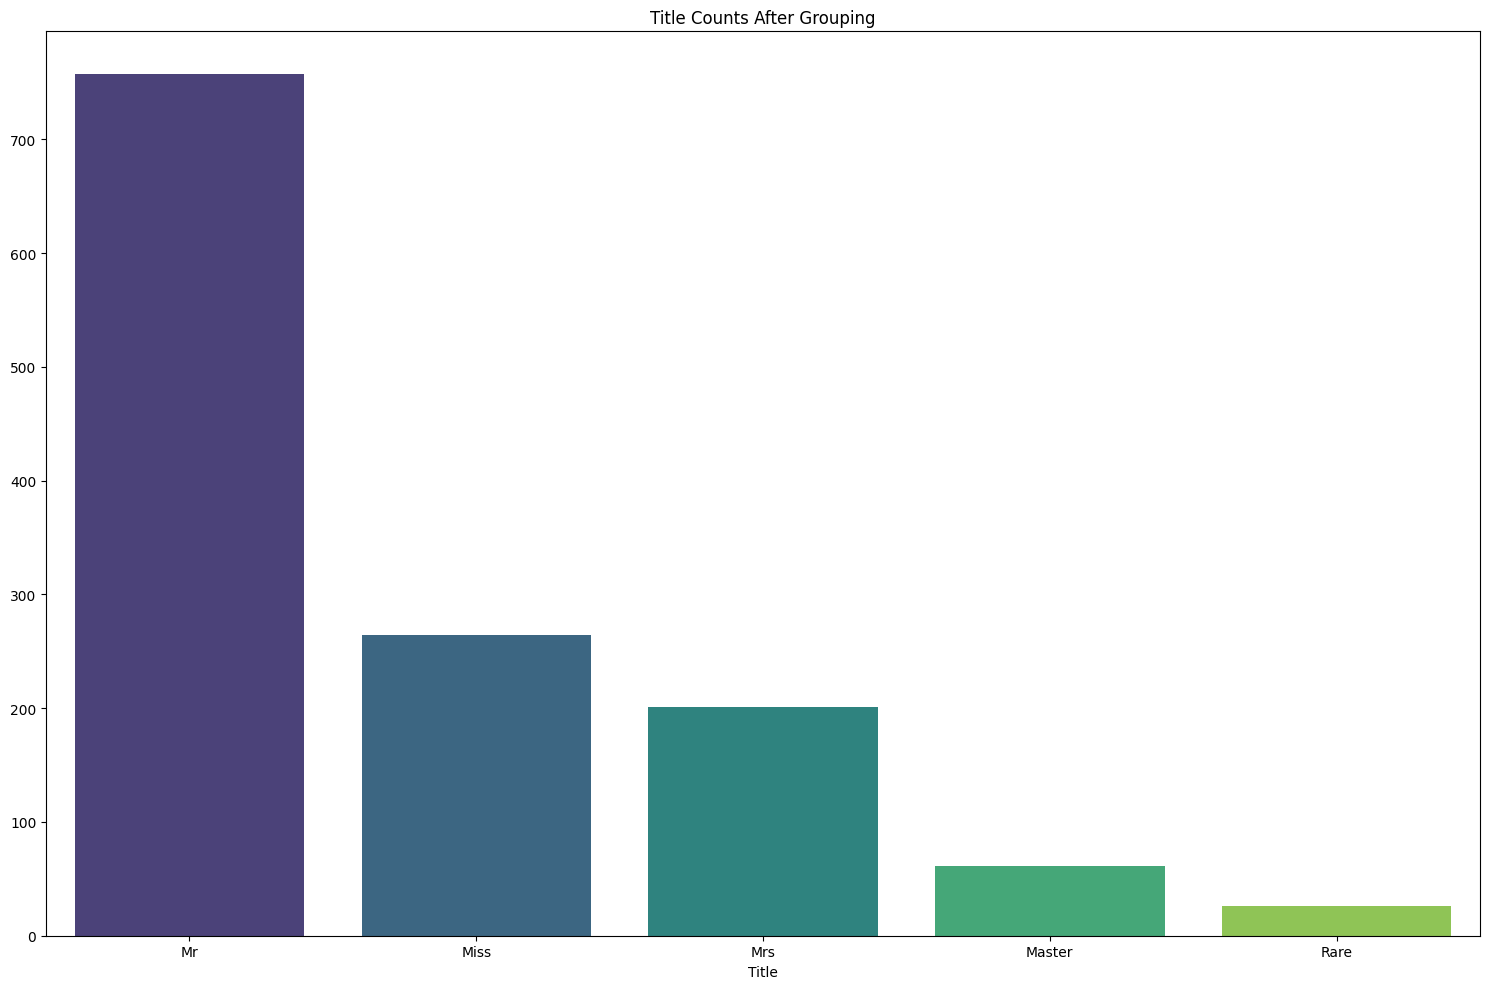

In [29]:
# Now plot the regrouped 'Title'
plt.figure(figsize=(15,10))
sns.barplot(x=all_data['Title'].value_counts().index,y=all_data['Title'].value_counts().values,palette='viridis')
plt.title('Title Counts After Grouping')

plt.tight_layout()
plt.show()

In [30]:
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1

#### Encoding: 
We should have a logic flow of how to create a new feature Connected survival Group based on ticket frequency, family...

1. Look at 'Ticket' first
2. If the ticket is unique, we trace to the family and see if the family member had purchased different kind of ticket or not.
3. A binary logic, if we still don't know, we split the survival rate into three branches:
   
   (1) Did anyone survived? - 1.0
   
   (2) I don't know - 0.5
   
   (3) Did everyone not survived? - 0.0


In [31]:
# First extract surnames from names

all_data['Surname'] = all_data['Name'].str.split(',',expand=True)[0]

# We already have ticket frequency. Now we will count the frequency of the 
all_data['Surname_Freq'] = all_data.groupby('Surname')['Surname'].transform('count')

# Now initialize the features we need
all_data['Family_SurRate'] = 0.5  # default is 'unknown'
all_data['Has_FamilyInfo'] = 0

for grp,df_grp in all_data.groupby(['Ticket']):
    if len(df_grp) > 1:
        # We should walk through everyone in the group
        for index,row in df_grp.iterrows():
            passengerID = row['PassengerId']

            others = df_grp.loc[df_grp['PassengerId'] != passengerID]

            # If at least one in the group survived
            if others['Survived'].max() == 1.0:
                all_data.loc[all_data['PassengerId'] == passengerID,'Family_SurRate'] = 1.0
                all_data.loc[all_data['PassengerId'] == passengerID,'Has_FamilyInfo'] = 1.0
            elif others['Survived'].max() == 0.0:
                all_data.loc[all_data['PassengerId'] == passengerID,'Family_SurRate'] = 0.0
                all_data.loc[all_data['PassengerId'] == passengerID,'Has_FamilyInfo'] = 1.0


# What if 'Ticket' didn't work? -- We use 'Surname'

for grp,df_grp in all_data.groupby(['Surname']):
    if len(df_grp) > 1:
        # We should walk through everyone in the family
        for index,row in df_grp.iterrows():
            passengerID = row['PassengerId']

            if all_data.loc[all_data['PassengerId'] == passengerID,'Has_FamilyInfo'].values[0] == 0.0:
                others = df_grp.loc[df_grp['PassengerId'] != passengerID]
                if others['Survived'].max() == 1.0:
                    all_data.loc[all_data['PassengerId'] == passengerID,'Family_SurRate'] = 1.0
                    all_data.loc[all_data['PassengerId'] == passengerID,'Has_FamilyInfo'] = 1.0
                elif others['Survived'].max() == 0.0:
                    all_data.loc[all_data['PassengerId'] == passengerID,'Family_SurRate'] = 0.0
                    all_data.loc[all_data['PassengerId'] == passengerID,'Has_FamilyInfo'] = 1.0

# Now new features are created

In [32]:
all_data.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Ticket_Freq,Title,FamilySize,Surname,Surname_Freq,Family_SurRate,Has_FamilyInfo
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,Mr,2,Braund,2,0.0,1
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Mrs,2,Cumings,2,0.5,0
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Miss,1,Heikkinen,1,0.5,0
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Mrs,2,Futrelle,2,0.0,1
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Mr,1,Allen,2,1.0,1


#### After the above encoding, now let's think about what are category features, what needed to be encoded:
1. Nominal categorical features (no order): Embarked, Sex, Title, Deck -- use one hot encoding (1 or 0)
2. Ordinal categorical features (with order): Age & Fare (binned),Pclass -- LabelEncoding (to make the model recognize the order of class, 3-2-1)
3. Computed features: Surname_Freq, Family_SurRate, Has_FamilyInfo,Ticket_Freq -- keep them
4. What to drop: Name, Ticket, Surname, PassengerId, SibSp, Parch

In [33]:
all_data['Age'] = all_data['Age'].astype(float)
all_data['Age'] = all_data['Age'].fillna(all_data.groupby('Title')['Age'].transform('median'))

# 4. Final Check
print(f"Remaining missing ages: {all_data['Age'].isnull().sum()}")

Remaining missing ages: 0


In [34]:
# Drop columns
cols_drop = ['PassengerId', 'Name','Surname', 'SibSp', 'Parch','Ticket']

all_data = all_data.drop(cols_drop,axis=1,errors='ignore')
all_data

,Age,Deck,Embarked,Fare,Pclass,Sex,Survived,Ticket_Freq,Title,FamilySize,Surname_Freq,Family_SurRate,Has_FamilyInfo
0,22.0,M,S,7.2500,3,male,0.0,1,Mr,2,2,0.0,1
1,38.0,ABC,C,71.2833,1,female,1.0,2,Mrs,2,2,0.5,0
2,26.0,M,S,7.9250,3,female,1.0,1,Miss,1,1,0.5,0
3,35.0,ABC,S,53.1000,1,female,1.0,2,Mrs,2,2,0.0,1
4,35.0,M,S,8.0500,3,male,0.0,1,Mr,1,2,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,29.0,M,S,8.0500,3,male,NaN,1,Mr,1,1,0.5,0
1305,39.0,C,C,108.9000,1,female,NaN,3,Mrs,1,1,1.0,1
1306,38.5,M,S,7.2500,3,male,NaN,1,Mr,1,1,0.5,0
1307,29.0,M,S,8.0500,3,male,NaN,1,Mr,1,4,0.5,0


In [35]:
# Encoding ordinal features

# Encode Sex 
all_data['Sex'] = all_data['Sex'].map({'male':0,'female':1})
all_data['Sex']

0       0
1       1
2       1
3       1
4       0
       ..
1304    0
1305    1
1306    0
1307    0
1308    0
Name: Sex, Length: 1309, dtype: int64

In [36]:
le = LabelEncoder()

encode_cols = ['Embarked','Title','Deck']

for col in encode_cols:
    if col in all_data.columns:
        all_data[col] = le.fit_transform(all_data[col])

all_data

,Age,Deck,Embarked,Fare,Pclass,Sex,Survived,Ticket_Freq,Title,FamilySize,Surname_Freq,Family_SurRate,Has_FamilyInfo
0,22.0,10,2,7.2500,3,0,0.0,1,2,2,2,0.0,1
1,38.0,1,0,71.2833,1,1,1.0,2,3,2,2,0.5,0
2,26.0,10,2,7.9250,3,1,1.0,1,1,1,1,0.5,0
3,35.0,1,2,53.1000,1,1,1.0,2,3,2,2,0.0,1
4,35.0,10,2,8.0500,3,0,0.0,1,2,1,2,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,29.0,10,2,8.0500,3,0,NaN,1,2,1,1,0.5,0
1305,39.0,3,0,108.9000,1,1,NaN,3,3,1,1,1.0,1
1306,38.5,10,2,7.2500,3,0,NaN,1,2,1,1,0.5,0
1307,29.0,10,2,8.0500,3,0,NaN,1,2,1,4,0.5,0


#### Before Modelling, what we have to do is: 
Different features have different ranges, we have tp scale them in order to let the model treat them fairly. 

In [37]:
# Using StandardScalar

# fisrt divide the training and testing dataset
train = all_data[:891]
X_test = all_data[891:].drop('Survived',axis=1)

X_train = train.drop('Survived',axis=1)
Y_train = train['Survived']

In [38]:
#scaler = StandardScaler() 

#X_train = scaler.fit_transform(X_train)  
# .fit_tranform()  fit to data and tranform it and return the transformed array
#X_train = scaler.fit_transform(X_train)

print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (891, 12)
Y_train shape: (891,)
X_test shape: (418, 12)


### Model: 
#### I choose RandomForestClassifier as the model, now we have to determine what is the value of each important parameters

# Since titanic's dataset is relatively small, I dont need a larger n_estimator, max_depth,and min_samples_leaf

# Initialize our rfc model

rf = RandomForestClassifier(random_state=42)

# Define the grid
param_grid = {
    'n_estimators':[100,200,300],
    'max_depth': [None, 6, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,
                           n_jobs=-1, verbose=1, scoring='accuracy')

grid_search.fit(X_train,Y_train)

print(f'The best parameters among param_grid is:{grid_search.best_params_}')
print(f'The Best CV score of it is:{grid_search.best_score_}')

In [39]:
# As shown above, we got the best set of parameters, now we'll apply it to test dataset

# Try limiting max_depth and requiring more samples per leaf
model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=4, random_state=1)
model.fit(X_train,Y_train)


scores = cross_val_score(model, X_train, Y_train, cv=5)
print("Accuracy:", scores.mean())

Accuracy: 0.8293955181721172


In [40]:
X_test.isnull().sum()

Age               0
Deck              0
Embarked          0
Fare              1
Pclass            0
Sex               0
Ticket_Freq       0
Title             0
FamilySize        0
Surname_Freq      0
Family_SurRate    0
Has_FamilyInfo    0
dtype: int64

In [41]:
Y_pred = model.predict(X_test)

Y_pred

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

#### Create Submission File

In [42]:
passID = test_data['PassengerId']

output = pd.DataFrame({
    'PassengerId': passID,
    'Survived': Y_pred})

output.to_csv('submission.csv',index=False)